#### 0) Introduction

In the last 6 months I've been enamored with cryptocurrency-related news, research, and investment.  During that time I came across an interesting model developed by anonymous Twitter Bitcoin expert [PlanB](https://twitter.com/100trillionUSD?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor) which has had a great deal of success predicting the price of Bitcoin (ticker symbol: BTC) since 2011:

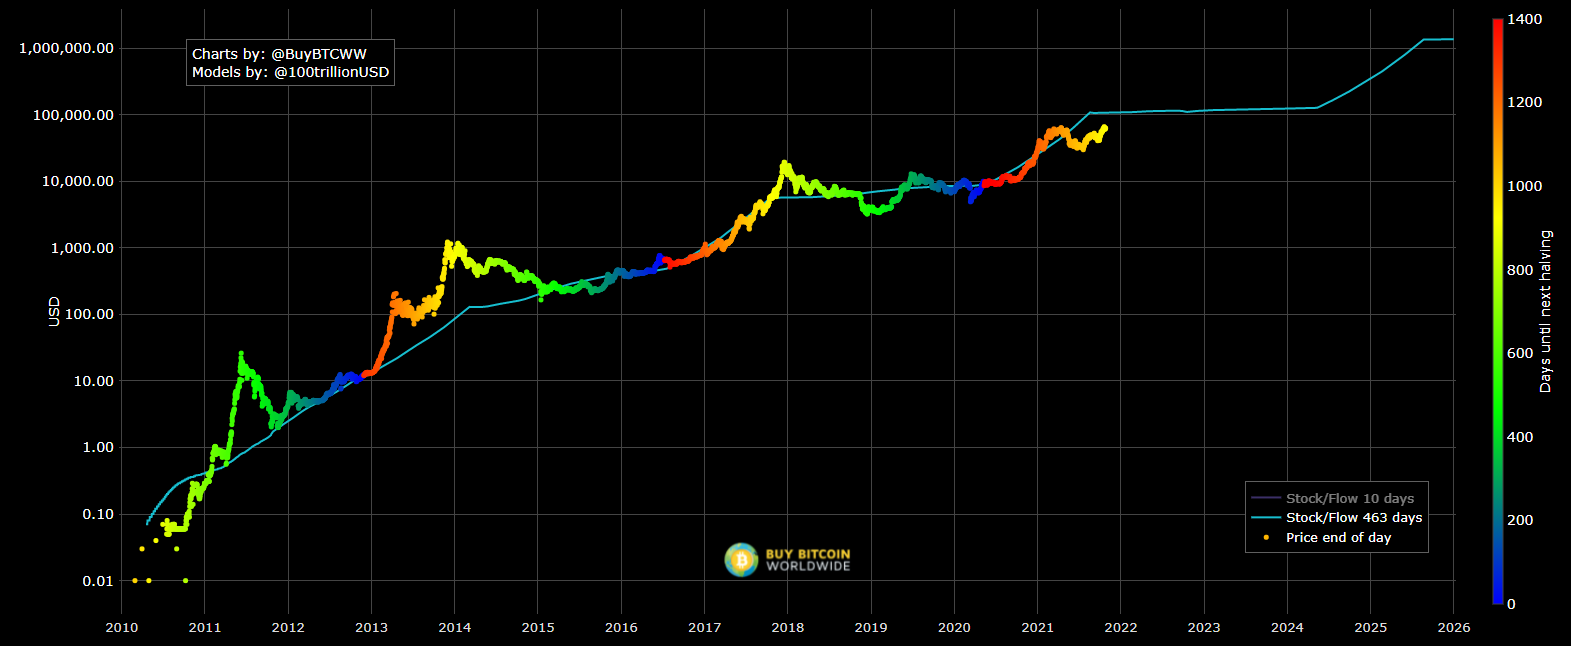
Source: [Bitcoin stock to flow model live chart](https://stats.buybitcoinworldwide.com/stock-to-flow/)

The model works by measuring the ratio of total Bitcoin mined worldwide (stock) to the rate of mining taking place currently (flow).  Additionally, Bitcoin's claim to fame is that 1) there will only ever be 21 million mined, and 2) as it is mined, the rate of production falls.  As a result of the designed scarcity, Bitcoin has seen its price rise in a predictable way when  measured against PlanB's stock-to-flow model.

In this workbook I use Facebook's Prophet time series model to predict the price of BTC.  Intuitively speaking, if the price has risen predictably since 2011, it seems like the price of BTC could be a great candidate for a simple time series model.

For the workbook, I'll be working with the standard NumPy stack, Yahoo Finance's Python API for loading the stock prices, SciKit-Learn for data preprocessing and hyperparameter selection, and of course Facebopok's Prophet package.

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Importing plotly failed. Interactive plots will not work.


#### 1) Data Import

Yahoo began tracking the price of BTC on September 17th, 2014, so I loaded daily records from then on through today (November 5th, 2021).

In [2]:
today = pd.to_datetime('today').date()

In [3]:
btc_df = yf.download('BTC-USD',
                     start='2014-09-17',
                     end=today,
                     progress=False)
btc_df.reset_index(inplace=True)
btc_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
btc_df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

The dataset is clean without null values, so there's no need to do any cleansing.  Thanks Yahoo!

For visualization I'll convert the dataset into a time series by converting the Date column into a datetime object, and will use the average of the Low and High prices as the metric to plot.  

In [5]:
btc_df['Date'] = pd.to_datetime(btc_df['Date'])
btc_df.set_index('Date', inplace=True)

In [6]:
btc_df['BTC'] = pd.DataFrame((btc_df['High']+btc_df['Low'])/2).rename(columns={0:'BTC'})

In [7]:
btc_ts = pd.DataFrame(btc_df['BTC']).rename(columns={0:'BTC'})

Now our BTC time series is ready for plotting.

In [8]:
btc_ts.head(5)

,BTC
Date,
2014-09-17,460.298004
2014-09-18,434.981995
2014-09-19,406.183502
2014-09-20,406.589493
2014-09-21,402.803497


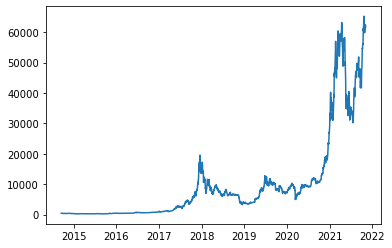

In [9]:
fig = pl.figure()
ax = fig.add_subplot(1,1,1)
line, = ax.plot(btc_ts['BTC'])

The price of BTC has increased dramatically in the last few years, so plotting and making predictions within a log-transformed price will yield better visualization and model predictions.  

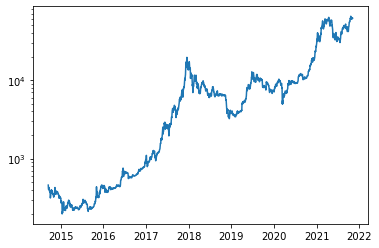

In [10]:
fig = pl.figure()
ax = fig.add_subplot(1,1,1)
line, = ax.plot(btc_ts['BTC'])
ax.set_yscale('log')

#### 2) Prophet Forecast

As stated in [Facebook Research's blog post describing how Prophet works](https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/), Prophet is an additive regression model with a few primary components:

 - a piecewise growth trend, which is defined by a number of trend "changepoints" that are either detected automatically by Prophet or optionally specified by the user.
 - yearly and weekly seasonal components
 - a list of important holidays, either supplied by the default Prophet database or entered manually by the user

The advantage of using Prophet lies in its changepoints.  Each changepoint marks a detectable change in trend of the time series, and the model fits seasonal components to each resulting partition.  In doing so, the model is able to not only pick up on the most relevant current trend for its forecast, but also identify consistent seasonal components which appear throughout the entire history set.

Below I'll fit the full dataset of average BTC price and show how Prophet automatically identifies changepoints, as well as how it breaks the time series down into seasonal components.  I'll begin by log-transforming the average daily price.

In [11]:
btc_df['Log'] = pd.DataFrame(np.log(btc_df['BTC'])).rename(columns={0:'Log'})

In [12]:
btc_fb = btc_df.reset_index()[['Date', 'Log']].rename(columns={'Date':'ds', 'Log':'y'})

Here I'm specifying 5 changepoints and a multiplicative seasonal model.  Additionally, I've gone ahead and added all of the known US holidays in the Prophet library for consideration as it fits the BTC price data.

In [13]:
btc_model = Prophet(n_changepoints=5,
                    seasonality_mode='multiplicative')
btc_model.add_country_holidays(country_name='US')

In [14]:
btc_model.fit(btc_fb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
btc_fb_predictions = btc_model.predict(btc_fb)

In the plot below, you can see how Prophet automatically placed the 5 changepoints in positions which capture significant differences in trend of the price of BTC.

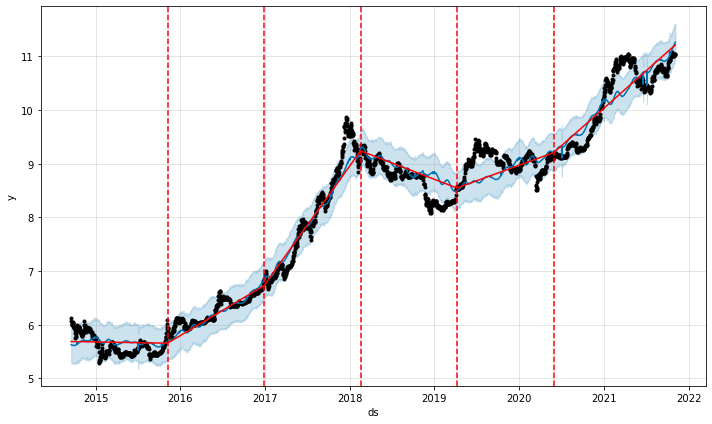

In [16]:
fig = btc_model.plot(btc_fb_predictions)
a = add_changepoints_to_plot(fig.gca(), btc_model, btc_fb_predictions)

The linear trends partitioned by the 5 changepoints are plotted below in the trend component plot.  Within those timeframes, Prophet also identified seasonal trends for holidays, weekly and yearly components.  

A few observations regarding the trends and seasonal components:

 - There appears to be a **regular decline in the Thanksgiving and Christmas timeframe** on the price of BTC.  In recent years it has been strongest, but it has varied anywhere **from approximately  -0.5% to -2.0%**.  When transformed back into terms of nominal dollars at an assumed price of \\$60k, that corresponds to a dependable decrease of **-\\$300 to -\\$1200**.  It seems that Christmas day is a great time to catch some BTC on sale!
 
 - By day-of-week, there is an **observable trend where Sunday is much lower than Saturday**, which might imply a profitable swing-trading strategy where one sells on Saturday, buys again on Sunday, and repeats the process.  However, with **percentages varying between -0.02% and +0.01%**, the amount one stands to **gain could be minimal**.
 
 - Additionally, there is an observable trend where BTC prices **bottom out in early October, and rise to their peak at the new year**.  Among the online crypto community, there is a notion of **"Up-tober"**, where investors internet-wide count on their **BTC holdings to grow in value between October and December**.  It's cool to see that notion depicted in the data!  Specifically, at a variation between **-1.5% and +1.5%** and an assumed price of \\$60k, that results in a range between **-\\$900 and +\\$900**.

C:\ProgramData\Anaconda3\envs\Prophet3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\ProgramData\Anaconda3\envs\Prophet3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\ProgramData\Anaconda3\envs\Prophet3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


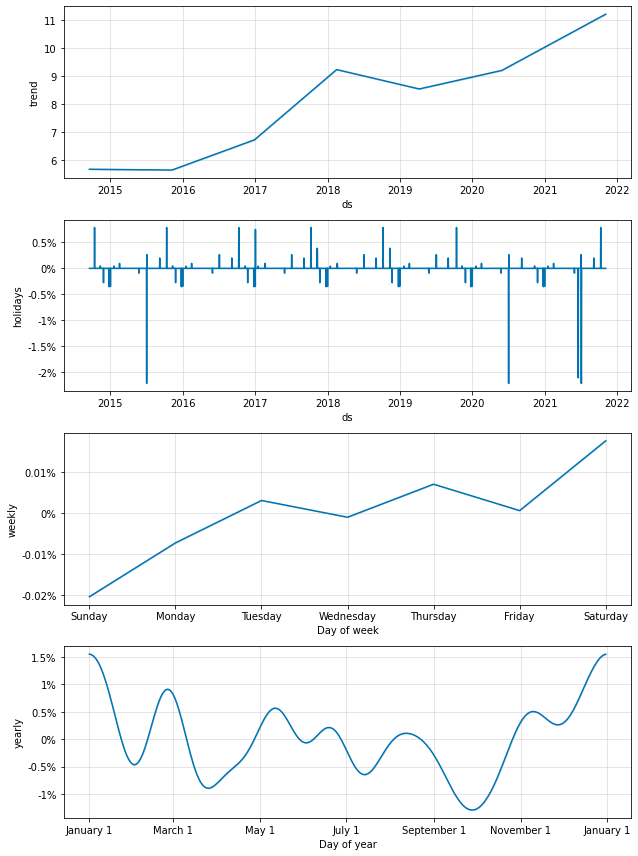

In [17]:
_ = btc_model.plot_components(btc_fb_predictions)

#### 3) Cross Validation and Hyperparameter Selection

In order to develop an accurate and robust BTC forecast, I'll consider two things in the selection of my model:

 - Hyperparameters, such as the number of changepoints and the seasonality mode
 - The forward-looking period to forecast (e.g. 30 or 90 days)
 
While it would be really convenient to be able to forecast tomorrow's price accurately, it's unlikely that a simple time series will pick apart the volatility with any consistency.  I'm more interested in making a prediction some number of months into the future.

In the **btc_model_cv()** function below, I use cross-validation to evaluate my hyperparameter and forecast period selections for model accuracy.  To do so, I train a model on a set of hyperparameters within a grid I define and evaluate the model's error.  To do so, I progressively test longer chunks of the data and assess the model's predictive power.  An example of the process is depicted below:

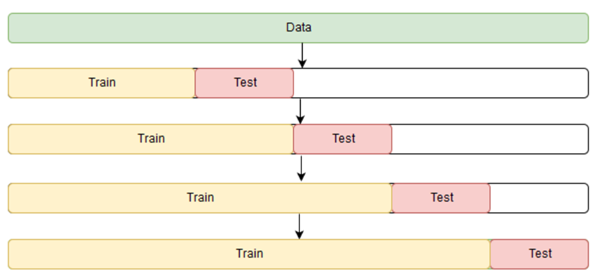

For each combination of hyperparameter selection and forecast period, I will measure cross-validated error, and select the pair that performs the best over the lifetime of BTC.

In [18]:
def btc_model_cv(btc_fb: pd.DataFrame(), prophet_param_grid: dict, regressors: list, n_ts_split: int) -> list:
    """
    Perform cross validation for a selected hyperparameter combination forecast period on the input time series.  It 
    returns both the parameters associated with the lowest cross-validated error and the full cross-validation history.
    
    Parameters
    ----------
    btc_fb: pd.DataFrame()
            A pandas dataframe with a minimum of two field: 'ds' and 'y'.  Facebook's Prophet() class will read the datetimes
            in the 'ds' column as the independent variable, and will build a forecast for target variable 'y'.
            
            Optionally, the user may include additional columns for use as regressors.  An example is included below which
            includes the exogenous variable (i.e. additional regressor) 'vol'.
            
            Ex:
                            ds     y      vol
              1     2021-11-04    20    50000
              2     2021-11-05    30    80000
              3     2021-11-06    40   120000
    
    prophet_param_grid: dict
            The dictionary which stores all hyperparameters and their selected values for testing with Prophet().  Every 
            combination of the hyperparameters specified will be tested and have their predictive power evaluated.  The 
            dictionary's keys should be strings whose values contain iterable objects which contain or generate the 
            hyperparameter selections.
            
            Ex:
                {'growth':['linear'],
                 'n_changepoints':[5,10,15,20,25],
                 'changepoint_range':[0.7,0.75,0.8,0.85,0.9],
                 'seasonality_mode':['additive','multiplicative'],
                 'forecast_period':[30,60,90,120,150]}
    
    regressors: list
            The list of fields which should be included in the model as regressors.  If there are no regressor fields, set
            regressors = None.
    
    ts_splits: int
            The number of splits to make on btc_fb for cross-validation.
    
    """
    # Initialize the return variables and iteration counter
    best_param_config = None
    param_configs = []
    i = 0
    # Loop through every hyperparameter configuration in the grid
    for param_config in prophet_param_grid:
        # Initialize the list which will include the errors for each ts_split
        btc_errs = []
        # Generate the splits on btc_fb for cross-validation with SciKit-Learn's TimeSeriesSplit class
        ts_splits = TimeSeriesSplit(n_splits=n_ts_split, test_size=param_config['forecast_period'])
        btc_splits = ts_splits.split(btc_fb)
        # For every btc_split, separate into training and test data and fit the Prophet model
        for btc_train_index, btc_test_index in btc_splits:
            btc_train, btc_test = btc_fb.iloc[btc_train_index], btc_fb.iloc[btc_test_index]
            # Create a Prophet model, specify hyperparameters according to each param_config in the outer loop, and add 
            # United States holidays for seasonal component analysis
            btc_model = Prophet(daily_seasonality=False,
                                growth=param_config['growth'],
                                n_changepoints=param_config['n_changepoints'],
                                changepoint_range=param_config['changepoint_range'],
                                seasonality_mode=param_config['seasonality_mode']).add_country_holidays(country_name='US')
            # If there are exogenous variables to include, add them to the model.
            if regressors is not None:
                for regressor in regressors:
                    btc_model.add_regressor(regressor)
            # Fit the prophet model on the training split
            btc_model.fit(btc_train)
            # Generate predictions for the test split, and convert them to nominal dollar amounts.  Calculate the loss
            btc_predictions = btc_model.predict(btc_test)
            btc_test.reset_index(inplace=True)
            btc_err = np.sqrt(mean_squared_error(np.exp(btc_predictions['yhat']),np.exp(btc_test['y'])))
            # Store this iteration's loss
            btc_errs.append(btc_err)
        # Calculate the mean of each train split loss, and compute cumulative loss for the hyperparameter/forecast period
        # combination
        fcst_btc_err = np.mean(btc_errs)
        # Append the hyperparameters, mean error, individual split test error, and forecast period to the param_configs 
        # return list
        param_configs.append([param_config, fcst_btc_err, btc_errs, param_config['forecast_period']])

        # Monitor which model has had the lowest overall error, and update best_param_config if a new model/forecast period 
        # performs better
        if best_param_config is None:
            best_param_config = [param_config, fcst_btc_err, btc_errs]
        elif fcst_btc_err < best_param_config[1]:
            best_param_config = [param_config, fcst_btc_err, btc_errs]
            
        # Update the counter, and print the training status to console
        i += 1
        print(f'\r{round(100*i/len(prophet_param_grid),1)}% of parameter configurations fit, lowest CV loss: {round(best_param_config[1],0)}', end='', flush=True)
        
    # Return the best-performing hyperparameter and forecast period, as well as full training history
    return best_param_config, param_configs

The hyperparameters I've chosen to test are:

 - n_changepoints: the number of changepoints Prophet will automatically identify in the time series
 - changepoint_range: a ratio between 0 and 1 which specifies the portion of the time series for which changepoints will be identified.  For example, if the changepoint_range is 0.8, then the first 80% of the time series will have a number of changepoints equal to n_changepoints identified.
 - seasonality_mode: determines whether the seasonal components are added or multiplied together.  The most significant impact is that, if the seasonal fluctuations are fairly constant (i.e. the amplitude doesn't change), additive will provide a better fit.  However, if the fluctuations tend to get larger as time goes on, multiplicative will more effectively capture those deviations.
 
My hyperparameter combinations are shown below, and it's time to cross-validate!

In [19]:
prophet_params = {'growth':['linear'],
                  'n_changepoints':[5,10,15,20,25],
                  'changepoint_range':[0.7,0.75,0.8,0.85,0.9],
                  'seasonality_mode':['additive','multiplicative'],
                  'forecast_period':[30,60,90,120,150]}
prophet_param_grid = ParameterGrid(prophet_params)

In [20]:
best_btc_params, btc_params = btc_model_cv(btc_fb=btc_fb,
                                           prophet_param_grid=prophet_param_grid,
                                           regressors=None,
                                           n_ts_split=10)

1.2% of parameter configurations fit, lowest CV loss: 15599.0

5.2% of parameter configurations fit, lowest CV loss: 9716.00

8.8% of parameter configurations fit, lowest CV loss: 8196.0

9.2% of parameter configurations fit, lowest CV loss: 8196.0

12.8% of parameter configurations fit, lowest CV loss: 8196.0

13.2% of parameter configurations fit, lowest CV loss: 8196.0

16.8% of parameter configurations fit, lowest CV loss: 8196.0

20.0% of parameter configurations fit, lowest CV loss: 8196.0

20.8% of parameter configurations fit, lowest CV loss: 8196.0

21.2% of parameter configurations fit, lowest CV loss: 8196.0

24.0% of parameter configurations fit, lowest CV loss: 8196.0

24.8% of parameter configurations fit, lowest CV loss: 8196.0

29.2% of parameter configurations fit, lowest CV loss: 8196.0

32.0% of parameter configurations fit, lowest CV loss: 8196.0

32.8% of parameter configurations fit, lowest CV loss: 8196.0

33.2% of parameter configurations fit, lowest CV loss: 8196.0

37.2% of parameter configurations fit, lowest CV loss: 8196.0

38.0% of parameter configurations fit, lowest CV loss: 8196.0

45.2% of parameter configurations fit, lowest CV loss: 8196.0

48.8% of parameter configurations fit, lowest CV loss: 8196.0

49.2% of parameter configurations fit, lowest CV loss: 8196.0

52.8% of parameter configurations fit, lowest CV loss: 8196.0

56.8% of parameter configurations fit, lowest CV loss: 8196.0

57.6% of parameter configurations fit, lowest CV loss: 8196.0

58.0% of parameter configurations fit, lowest CV loss: 8196.0

60.8% of parameter configurations fit, lowest CV loss: 8196.0

64.4% of parameter configurations fit, lowest CV loss: 8196.0

64.8% of parameter configurations fit, lowest CV loss: 8196.0

68.8% of parameter configurations fit, lowest CV loss: 8196.0

72.8% of parameter configurations fit, lowest CV loss: 8196.0

84.0% of parameter configurations fit, lowest CV loss: 6668.0

84.4% of parameter configurations fit, lowest CV loss: 6668.0

88.0% of parameter configurations fit, lowest CV loss: 6668.0

88.4% of parameter configurations fit, lowest CV loss: 6668.0

93.2% of parameter configurations fit, lowest CV loss: 6668.0

96.4% of parameter configurations fit, lowest CV loss: 6668.0

97.2% of parameter configurations fit, lowest CV loss: 6668.0

100.0% of parameter configurations fit, lowest CV loss: 6668.0

In [21]:
n_changepoints = best_btc_params[0]['n_changepoints']
changepoint_range = best_btc_params[0]['changepoint_range']
seasonality_mode = best_btc_params[0]['seasonality_mode']
forecast_period = best_btc_params[0]['forecast_period']
rmse = best_btc_params[1]
print('Best BTC Prophet Parameters:\n',
      f'  # Changepoints:        {n_changepoints}\n',
      f'  Changepoint Range:     {changepoint_range}\n',
      f'  Seasonality Mode:      {seasonality_mode}\n',
      f'  Forecast Period:       {forecast_period} days\n',
      '\n',
      f'  Cross-Validated Loss:  ${round(rmse,1)}',
      sep='')

Best BTC Prophet Parameters:
  # Changepoints:        25
  Changepoint Range:     0.85
  Seasonality Mode:      multiplicative
  Forecast Period:       120 days

  Cross-Validated Loss:  $6668.2


#### 4) Predictions

Now that an optimal hyperparameter and forecast period combination has been identified, I'll fit a model with the selected hyperparameters.  The optimal forecast period gives us a notion of how far we should expect the model to perform effectively into the future.

In [22]:
best_btc_model = Prophet(daily_seasonality=False,
                         growth=best_btc_params[0]['growth'],
                         n_changepoints=best_btc_params[0]['n_changepoints'],
                         changepoint_range=best_btc_params[0]['changepoint_range'],
                         seasonality_mode=best_btc_params[0]['seasonality_mode']).add_country_holidays(country_name='US')
best_btc_model.fit(btc_fb)

Here we will create a set of predictions for the number of days specified by the optimal forecast period.

In [23]:
best_btc_param_period = best_btc_params[0]['forecast_period']
best_btc_forecast = pd.DataFrame(pd.date_range(today, periods=best_btc_param_period)).rename(columns={0:'ds'})
best_btc_forecast = best_btc_model.predict(best_btc_forecast)

And finally, I'll plot the most recent BTC history alongside the predictions we've generated for our forecast period.

In [24]:
btc_fb.set_index(btc_fb['ds'], inplace=True)
best_btc_forecast.set_index(best_btc_forecast['ds'], inplace=True)

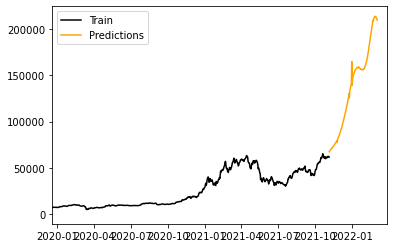

In [25]:
pl.plot(np.exp(btc_fb['y']), color='black', label='Train')
pl.plot(np.exp(best_btc_forecast['yhat']), color='orange', label='Predictions')
pl.xlim([18250,19080])
pl.legend(loc='upper left')
pl.show()

Now that I have a forecast ready to go, I wanted to pick a couple of notable dates to generate predictions for.  I figured Thanksgiving and Christmas would be solid days to consider, so below are the predictions for BTC on the next couple of holidays:

In [26]:
thx_best_btc = np.exp(best_btc_forecast.loc[best_btc_forecast['ds']=='2021-11-25']['yhat'][0])
xms_best_btc = np.exp(best_btc_forecast.loc[best_btc_forecast['ds']=='2021-12-25']['yhat'][0])
print(f'BTC price by Thanksgiving 2021: $ {int(thx_best_btc)}')
print(f'BTC price by Christmas 2021:    ${int(xms_best_btc)}')

BTC price by Thanksgiving 2021: $ 77474
BTC price by Christmas 2021:    $125571


Let me tell ya, I would not hate a $126k BTC on Christmas!

#### 5) Exogenous Variables

One of the coolest features of the Prophet model is that you can very easily include exogenous variables in your forecast.  For example, in the plot below you can clearly see that the trading volume of BTC followed the price of BTC almost exactly leading up to its original peak in 2018.  At that time, a ton of news broke on BTC, and people outside of the internet became very aware of what it was, and how much the price had grown.  However, following that time you can see a clear departure in trend for both price and volume.

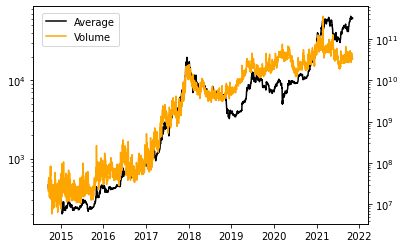

In [27]:
fig, ax1 = pl.subplots()
ax2 = ax1.twinx()
ax1.plot(btc_df['BTC'], label='Average', color='black')
ax2.plot(btc_df['Volume'], label='Volume', color='orange')
ax1.set_yscale('log')
ax2.set_yscale('log')
fig.legend(loc='upper left', bbox_to_anchor=(0.135,0.875))
pl.show()

In the next few cells, I'm going to cross-validate a BTC forecast with volume included as an exogenous variable.  Then, because you can't make predictions with an exogenous forecast without predictions for your exogenous variable, I'll fit a simple time series model for volume to include in our exogenous BTC forecast.

In [28]:
btc_fb_exog = btc_df.reset_index()[['Date', 'Log', 'Volume']].rename(columns={'Date':'ds', 'Log':'y', 'Volume':'vol'})

In [29]:
btc_fb_exog['vol'] = np.log(btc_fb_exog['vol'])

In [30]:
exog_best_btc_params, exog_btc_params = btc_model_cv(btc_fb=btc_fb_exog,
                                                     prophet_param_grid=prophet_param_grid,
                                                     regressors=['vol'],
                                                     n_ts_split=10)

1.2% of parameter configurations fit, lowest CV loss: 15798.0

4.0% of parameter configurations fit, lowest CV loss: 15798.0

8.0% of parameter configurations fit, lowest CV loss: 10204.0

8.8% of parameter configurations fit, lowest CV loss: 8579.0

9.2% of parameter configurations fit, lowest CV loss: 8516.0

12.8% of parameter configurations fit, lowest CV loss: 8516.0

16.0% of parameter configurations fit, lowest CV loss: 8516.0

16.8% of parameter configurations fit, lowest CV loss: 8516.0

20.0% of parameter configurations fit, lowest CV loss: 8516.0

20.8% of parameter configurations fit, lowest CV loss: 8516.0

21.6% of parameter configurations fit, lowest CV loss: 8516.0

24.0% of parameter configurations fit, lowest CV loss: 8516.0

28.4% of parameter configurations fit, lowest CV loss: 7761.0

28.8% of parameter configurations fit, lowest CV loss: 7761.0

29.2% of parameter configurations fit, lowest CV loss: 7761.0

29.6% of parameter configurations fit, lowest CV loss: 7761.0

32.0% of parameter configurations fit, lowest CV loss: 7761.0

36.0% of parameter configurations fit, lowest CV loss: 7761.0

36.4% of parameter configurations fit, lowest CV loss: 7761.0

36.8% of parameter configurations fit, lowest CV loss: 7761.0

37.2% of parameter configurations fit, lowest CV loss: 7761.0

41.2% of parameter configurations fit, lowest CV loss: 7761.0

45.2% of parameter configurations fit, lowest CV loss: 7761.0

53.2% of parameter configurations fit, lowest CV loss: 7761.0

56.8% of parameter configurations fit, lowest CV loss: 7761.0

57.2% of parameter configurations fit, lowest CV loss: 7761.0

64.4% of parameter configurations fit, lowest CV loss: 7761.0

81.2% of parameter configurations fit, lowest CV loss: 6196.0

84.4% of parameter configurations fit, lowest CV loss: 6196.0

85.2% of parameter configurations fit, lowest CV loss: 6196.0

88.0% of parameter configurations fit, lowest CV loss: 6196.0

88.4% of parameter configurations fit, lowest CV loss: 6196.0

89.2% of parameter configurations fit, lowest CV loss: 6196.0

94.0% of parameter configurations fit, lowest CV loss: 6196.0

96.0% of parameter configurations fit, lowest CV loss: 6196.0

97.2% of parameter configurations fit, lowest CV loss: 6196.0

100.0% of parameter configurations fit, lowest CV loss: 6196.0

In [42]:
exog_n_changepoints = exog_best_btc_params[0]['n_changepoints']
exog_changepoint_range = exog_best_btc_params[0]['changepoint_range']
exog_seasonality_mode = exog_best_btc_params[0]['seasonality_mode']
exog_forecast_period = exog_best_btc_params[0]['forecast_period']
exog_rmse = exog_best_btc_params[1]
print('Best BTC Exogenous Prophet Parameters:\n',
      f'  # Changepoints:        {exog_n_changepoints}\n',
      f'  Changepoint Range:     {exog_changepoint_range}\n',
      f'  Seasonality Mode:      {exog_seasonality_mode}\n',
      f'  Forecast Period:       {exog_forecast_period} days\n',
      '\n',
      f'  Cross-Validated Loss:  ${round(exog_rmse,1)}',
      sep='')

Best BTC Exogenous Prophet Parameters:
  # Changepoints:        25
  Changepoint Range:     0.85
  Seasonality Mode:      multiplicative
  Forecast Period:       120 days

  Cross-Validated Loss:  $6195.6


The difference isn't massive, but there is a 6.9% decrease in cross-validation loss from ~\\$6700 to ~\\$6200 when volume is included as an exogenous variable in our BTC forecast.  I'd say that's at least compelling enough to create a volume forecast and see how the results differ.

Below we'll run through the same cross-validation process to identify optimal hyperparameters and forecast period for a volume forecast.

In [32]:
btc_vol = btc_df.reset_index()[['Date','Volume']].rename(columns={'Date':'ds','Volume':'y'})

In [33]:
btc_vol['y'] = np.log(btc_vol['y'])

In [34]:
best_vol_params, vol_params = btc_model_cv(btc_fb=btc_vol,
                                           prophet_param_grid=prophet_param_grid,
                                           regressors=None,
                                           n_ts_split=10)

1.2% of parameter configurations fit, lowest CV loss: 18547786158.0

5.2% of parameter configurations fit, lowest CV loss: 17548910581.0

12.0% of parameter configurations fit, lowest CV loss: 17548910581.0

16.0% of parameter configurations fit, lowest CV loss: 17548910581.0

17.2% of parameter configurations fit, lowest CV loss: 17548910581.0

21.2% of parameter configurations fit, lowest CV loss: 17548910581.0

21.6% of parameter configurations fit, lowest CV loss: 17548910581.0

24.8% of parameter configurations fit, lowest CV loss: 17548910581.0

29.2% of parameter configurations fit, lowest CV loss: 17548910581.0

29.6% of parameter configurations fit, lowest CV loss: 17548910581.0

32.8% of parameter configurations fit, lowest CV loss: 17548910581.0

33.2% of parameter configurations fit, lowest CV loss: 17548910581.0

36.0% of parameter configurations fit, lowest CV loss: 17384174661.0

36.8% of parameter configurations fit, lowest CV loss: 17384174661.0

37.2% of parameter configurations fit, lowest CV loss: 17384174661.0

40.0% of parameter configurations fit, lowest CV loss: 17384174661.0

40.4% of parameter configurations fit, lowest CV loss: 17384174661.0

44.8% of parameter configurations fit, lowest CV loss: 17384174661.0

48.0% of parameter configurations fit, lowest CV loss: 17384174661.0

48.4% of parameter configurations fit, lowest CV loss: 17384174661.0

48.8% of parameter configurations fit, lowest CV loss: 17384174661.0

56.4% of parameter configurations fit, lowest CV loss: 14455931967.0

60.8% of parameter configurations fit, lowest CV loss: 14455931967.0

61.2% of parameter configurations fit, lowest CV loss: 14455931967.0

64.0% of parameter configurations fit, lowest CV loss: 14455931967.0

64.8% of parameter configurations fit, lowest CV loss: 14455931967.0

65.2% of parameter configurations fit, lowest CV loss: 14455931967.0

68.4% of parameter configurations fit, lowest CV loss: 14455931967.0

68.8% of parameter configurations fit, lowest CV loss: 14455931967.0

72.0% of parameter configurations fit, lowest CV loss: 14455931967.0

72.8% of parameter configurations fit, lowest CV loss: 14455931967.0

73.2% of parameter configurations fit, lowest CV loss: 14455931967.0

76.4% of parameter configurations fit, lowest CV loss: 14455931967.0

77.2% of parameter configurations fit, lowest CV loss: 14455931967.0

80.0% of parameter configurations fit, lowest CV loss: 14455931967.0

80.4% of parameter configurations fit, lowest CV loss: 14455931967.0

84.0% of parameter configurations fit, lowest CV loss: 14455931967.0

84.4% of parameter configurations fit, lowest CV loss: 14455931967.0

84.8% of parameter configurations fit, lowest CV loss: 14455931967.0

88.0% of parameter configurations fit, lowest CV loss: 14455931967.0

88.8% of parameter configurations fit, lowest CV loss: 14455931967.0

92.0% of parameter configurations fit, lowest CV loss: 14455931967.0

92.8% of parameter configurations fit, lowest CV loss: 14455931967.0

96.0% of parameter configurations fit, lowest CV loss: 14455931967.0

96.4% of parameter configurations fit, lowest CV loss: 14455931967.0

96.8% of parameter configurations fit, lowest CV loss: 14455931967.0

97.6% of parameter configurations fit, lowest CV loss: 14455931967.0

100.0% of parameter configurations fit, lowest CV loss: 14455931967.0

In [35]:
best_btc_vol_model = Prophet(daily_seasonality=False,
                             growth=best_vol_params[0]['growth'],
                             n_changepoints=best_vol_params[0]['n_changepoints'],
                             changepoint_range=best_vol_params[0]['changepoint_range'],
                             seasonality_mode=best_vol_params[0]['seasonality_mode']).add_country_holidays(country_name='US')
best_btc_vol_model.fit(btc_vol)

In [43]:
vol_n_changepoints = best_vol_params[0]['n_changepoints']
vol_changepoint_range = best_vol_params[0]['changepoint_range']
vol_seasonality_mode = best_vol_params[0]['seasonality_mode']
vol_forecast_period = best_vol_params[0]['forecast_period']
vol_rmse = best_vol_params[1]
print('Best BTC Volume Prophet Parameters:\n',
      f'  # Changepoints:        {vol_n_changepoints}\n',
      f'  Changepoint Range:     {vol_changepoint_range}\n',
      f'  Seasonality Mode:      {vol_seasonality_mode}\n',
      f'  Forecast Period:       {vol_forecast_period} days\n',
      '\n',
      f'  Cross-Validated Loss:  ${round(vol_rmse,1)}',
      sep='')

Best BTC Volume Prophet Parameters:
  # Changepoints:        10
  Changepoint Range:     0.8
  Seasonality Mode:      additive
  Forecast Period:       120 days

  Cross-Validated Loss:  $14455931966.9


Now we have our volume model fit and ready to go.  Conveniently, the optimal forecast period remains 120 days, so we don't need to worry about forecast period limitations due to volume.

We will fit the model exactly the same way as before, using the optimal BTC hyperparameters and forecast period to generate forecasted values.  However, this time we will add the regressor 'vol' from our btc_fb_exog dataframe.

In [37]:
best_exog_btc_model = Prophet(daily_seasonality=False,
                              growth=exog_best_btc_params[0]['growth'],
                              n_changepoints=exog_best_btc_params[0]['n_changepoints'],
                              changepoint_range=exog_best_btc_params[0]['changepoint_range'],
                              seasonality_mode=exog_best_btc_params[0]['seasonality_mode']).add_country_holidays(country_name='US')
best_exog_btc_model.add_regressor('vol')
best_exog_btc_model.fit(btc_fb_exog)

Next, we'll generate a time series with the next 120 dates and use it to calculate forecasted volume figures.

In [38]:
best_exog_btc_param_period = exog_best_btc_params[0]['forecast_period']
best_exog_btc_forecast = pd.DataFrame(pd.date_range(today, periods=best_exog_btc_param_period)).rename(columns={0:'ds'})
best_btc_vol_forecast = best_btc_vol_model.predict(best_exog_btc_forecast)

With volume values in hand, we'll add those to our existing best_exog_btc_forecast dataframe and predict the BTC values with its exogenous variables included.

In [39]:
best_exog_btc_forecast['vol'] = best_btc_vol_forecast['yhat']
best_exog_btc_forecast = best_exog_btc_model.predict(best_exog_btc_forecast)
best_exog_btc_forecast.set_index(best_exog_btc_forecast['ds'], inplace=True)

And now for the final results!

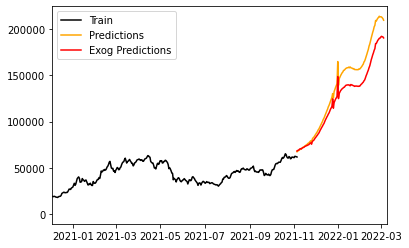

In [40]:
pl.plot(np.exp(btc_fb['y']), color='black', label='Train')
pl.plot(np.exp(best_btc_forecast['yhat']), color='orange', label='Predictions')
pl.plot(np.exp(best_exog_btc_forecast['yhat']), color='red', label='Exog Predictions')
pl.xlim([18600,19060])
pl.legend(loc='upper left')
pl.show()

It was clear in our original BTC/volume plot that the trend change in volume corresponded to a decreased price of BTC.  The model has picked up on that, and as a result has forecasted a lower future price of BTC.  It is also interesting that the inclusion of volume has seemed to impact the forecasted significance of Thanksgiving and Christmas on the price of BTC.

Specifically, it seems that between the two models, we see a **~\\$2,200 or ~2.8% decline** in predicted price by **Thanksgiving**, and a **~\\$11,500 or ~9.1% decline** by **Christmas**.

In [41]:
thx_best_btc = np.exp(best_btc_forecast.loc[best_btc_forecast['ds']=='2021-11-25']['yhat'][0])
xms_best_btc = np.exp(best_btc_forecast.loc[best_btc_forecast['ds']=='2021-12-25']['yhat'][0])
thx_exog_best_btc = np.exp(best_exog_btc_forecast.loc[best_exog_btc_forecast['ds']=='2021-11-25']['yhat'][0])
xms_exog_best_btc = np.exp(best_exog_btc_forecast.loc[best_exog_btc_forecast['ds']=='2021-12-25']['yhat'][0])
print(f'BTC price by Thanksgiving 2021 (TSA only):         ${int(thx_best_btc)}')
print(f'BTC price by Thanksgiving 2021 (Exogenous Volume): ${int(thx_exog_best_btc)}')
print('\n')
print(f'BTC price by Christmas 2021 (TSA only):            ${int(xms_best_btc)}')
print(f'BTC price by Christmas 2021 (Exogenous Volume):    ${int(xms_exog_best_btc)}')

BTC price by Thanksgiving 2021 (TSA only):         $77474
BTC price by Thanksgiving 2021 (Exogenous Volume): $75535


BTC price by Christmas 2021 (TSA only):            $125571
BTC price by Christmas 2021 (Exogenous Volume):    $114493


#### 6) Closing

At the time of creating this notebook these dates have not yet come to pass, so I haven't been able to validate how close these predictions will be.  However, I have let several family members and friends that I'm officially calling these numbers, so you could say I've put my money where my mouth is!

In the coming months, I plan to look back on these predictions and provide commentary in this section on how well the models held up.  Stay tuned!